In [1]:
import plotly.express as px
import pandas as pd
from pyspark.sql import SparkSession , Row , functions as F 
from pyspark.ml.feature import VectorAssembler , StandardScaler
from pyspark.ml.clustering import GaussianMixture , BisectingKMeans , KMeans
from pyspark.ml.classification import LogisticRegression , RandomForestClassifier
from pyspark.ml.evaluation import ClusteringEvaluator , MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator , ParamGridBuilder
from pyspark.ml import Pipeline


**CREATION DE LA SESSION SPARK**

In [2]:
spark = SparkSession.builder.appName("OnlineRetail").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/02/13 07:55:26 WARN Utils: Your hostname, MacBook-Pro-5.local, resolves to a loopback address: 127.0.0.1; using 10.46.11.185 instead (on interface en0)
26/02/13 07:55:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/13 07:55:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


**CHARGEMENT DU CSV**

In [3]:
data = spark.read.csv(
    "file:///Users/admin/Desktop/Spark/projet_spark/data/Online_Retail_CSV.csv",
    header=True,
    inferSchema=True,
    sep=";"
)


**EDA**

In [4]:
data.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [5]:
data.show(5, vertical=True)

-RECORD 0---------------------------
 InvoiceNo   | 536365               
 StockCode   | 85123A               
 Description | WHITE HANGING HEA... 
 Quantity    | 6                    
 InvoiceDate | 01/12/2010 08:26     
 UnitPrice   | 2,55                 
 CustomerID  | 17850                
 Country     | United Kingdom       
-RECORD 1---------------------------
 InvoiceNo   | 536365               
 StockCode   | 71053                
 Description | WHITE METAL LANTERN  
 Quantity    | 6                    
 InvoiceDate | 01/12/2010 08:26     
 UnitPrice   | 3,39                 
 CustomerID  | 17850                
 Country     | United Kingdom       
-RECORD 2---------------------------
 InvoiceNo   | 536365               
 StockCode   | 84406B               
 Description | CREAM CUPID HEART... 
 Quantity    | 8                    
 InvoiceDate | 01/12/2010 08:26     
 UnitPrice   | 2,75                 
 CustomerID  | 17850                
 Country     | United Kingdom       
-

In [6]:
print("Nombre de lignes : ", data.count())
print("Nombre de colonnes : ", len(data.columns))

Nombre de lignes :  541909
Nombre de colonnes :  8


In [7]:
# On check que StockCode correspond bien à un produit unique.
data.filter(F.col("StockCode") == "71053").show(5)

+---------+---------+-------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|        Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+-------------------+--------+----------------+---------+----------+--------------+
|   536365|    71053|WHITE METAL LANTERN|       6|01/12/2010 08:26|     3,39|     17850|United Kingdom|
|   536373|    71053|WHITE METAL LANTERN|       6|01/12/2010 09:02|     3,39|     17850|United Kingdom|
|   536375|    71053|WHITE METAL LANTERN|       6|01/12/2010 09:32|     3,39|     17850|United Kingdom|
|   536396|    71053|WHITE METAL LANTERN|       6|01/12/2010 10:51|     3,39|     17850|United Kingdom|
|   536406|    71053|WHITE METAL LANTERN|       8|01/12/2010 11:33|     3,39|     17850|United Kingdom|
+---------+---------+-------------------+--------+----------------+---------+----------+--------------+
only showing top 5 rows


In [8]:
print(f"Nombre de clients uniques : {data.select('CustomerID').distinct().count()}")
print(f"Nombre de factures distinctes : {data.select('InvoiceNo').distinct().count()}")
print(f"Nombre de pays : {data.select('Country').distinct().count()}")
print(f"Nombre de produits : {data.select('StockCode').distinct().count()}")


Nombre de clients uniques : 4373


Nombre de factures distinctes : 25900


Nombre de pays : 38
Nombre de produits : 4070


In [9]:
data.select("Quantity").describe().show()

+-------+------------------+
|summary|          Quantity|
+-------+------------------+
|  count|            541909|
|   mean|  9.55224954743324|
| stddev|218.08115785023418|
|    min|            -80995|
|    max|             80995|
+-------+------------------+



On remarque que Quantity s'étend de -80995 à 80995 avec une moyenne de 9.5 et un écart type de 218. Cela indique une forte présence d'outliers. Ceci est confirmé par le graph ci-dessous:

In [10]:
df = data.select("Quantity").sample(0.1, seed=42).toPandas()
fig = px.violin(
    df,
    y="Quantity",
    box=True,
    points="outliers",
    title="Violin plot de la quantité"
)
fig.show()



Les valeurs extrêmes observées pour Quantity (jusqu’à 80 995 unités) ne correspondent pas à des achats individuels classiques, mais probablement à des commandes en gros ou à des corrections comptables (retours/annulations).
Ces valeurs extrêmes ont un impact important sur les statistiques et les modèles, et doivent être traitées avec précaution. Dans un premier temps , supprimons les retours.

In [11]:
data = data.filter(F.col("Quantity") >= 0)


**CHECK VALEURS MANQUANTES**

In [12]:
null_counts = data.select([F.sum(F.col(c).isNull().cast("int")).alias(c)
             for c in data.columns])
null_counts.show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|        592|       0|          0|        0|    133361|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



Ici on décide supprimer les lignes ou l'identifiant client est manquant : on en aura nécessairement besoin plus tard pour la segmentation client. 

In [13]:
count_before = data.count()
data_clean = data.filter(F.col("CustomerID").isNotNull())
count_after = data_clean.count() 

print(f"Nombre de lignes avant nettoyage : {count_before}")
print(f"Nombre de lignes après nettoyage : {count_after}")
print(f"Nombre de lignes supprimées : {count_before - count_after}")

Nombre de lignes avant nettoyage : 531285
Nombre de lignes après nettoyage : 397924
Nombre de lignes supprimées : 133361


On peut garder les lignes avec la Description manquante , elle ne sera pas utilisée pour notre modèle. On remplace simplement ces valeurs NaN par Unknown. 

In [14]:
data_clean = data_clean.fillna({"Description": "Unknown"})

**CHECK ET SUPPRESSION LIGNES DUPLIQUEES**

In [15]:
before = data_clean.count()

data_clean = data_clean.dropDuplicates()

after = data_clean.count()
print("Avant :", before, "| Après :", after, "| Supprimées :", before - after)


Avant : 397924 | Après : 392732 | Supprimées : 5192


**CONVERSION TYPES COLONNES**

On converti les valeurs UnitPrice pour que le séparateur soit un point et non une virgule afin de pouvoir performer le casting plus tard.

In [16]:
data_clean = data_clean.withColumn(
    "UnitPrice_cleaned",
    F.regexp_replace(F.col("UnitPrice"), ",", ".")
)

On convertit la colonne InvoiceDate en time-stamp en précisant le format. 

In [17]:
data_clean = data_clean.withColumn("InvoiceDate", F.to_timestamp(F.col("InvoiceDate"), "dd/MM/yyyy HH:mm"))


On convertit UnitPrice en double afin de pouvoir l'utiliser dans nos modèles plus tard. 

In [18]:
data_clean = data_clean.withColumn("UnitPrice_cleaned", F.col("UnitPrice_cleaned").cast("double"))

On vérifie.

In [19]:
data_clean.select("InvoiceDate").show(5,truncate=False)

+-------------------+
|InvoiceDate        |
+-------------------+
|2010-12-01 08:34:00|
|2010-12-01 11:33:00|
|2010-12-01 11:45:00|
|2010-12-01 11:49:00|
|2010-12-01 12:23:00|
+-------------------+
only showing top 5 rows


In [20]:
data_clean.select("UnitPrice_cleaned").describe().show()

+-------+------------------+
|summary| UnitPrice_cleaned|
+-------+------------------+
|  count|            392732|
|   mean|3.1255955307945014|
| stddev| 22.24072528142609|
|    min|               0.0|
|    max|           8142.75|
+-------+------------------+



On supprime le UnitPrice original en string.

In [21]:
data_clean = data_clean.drop("UnitPrice").withColumnRenamed("UnitPrice_cleaned", "UnitPrice")

On vérifie que tout est OK.

In [22]:
data_clean.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = false)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- UnitPrice: double (nullable = true)



In [23]:
null_counts = data_clean.select([F.sum(F.col(c).isNull().cast("int")).alias(c)
             for c in data_clean.columns])
null_counts.show()

+---------+---------+-----------+--------+-----------+----------+-------+---------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|CustomerID|Country|UnitPrice|
+---------+---------+-----------+--------+-----------+----------+-------+---------+
|        0|        0|          0|       0|          0|         0|      0|        0|
+---------+---------+-----------+--------+-----------+----------+-------+---------+



**CREATION DE NOUVELLES COLONNES**

On crée une nouvelle colonne "TotalPrice" pour obtenir le total du prix par commande.

In [24]:
data_clean = data_clean.withColumn("TotalPrice", F.col("Quantity") * F.col("UnitPrice"))
data_clean.select("TotalPrice").show(5)

+----------+
|TotalPrice|
+----------+
|      25.5|
|      71.5|
|      2.52|
|      34.8|
|     13.52|
+----------+
only showing top 5 rows


**CREATION DU DATAFRAME RFM**

On copie le dataset original et on refiltre par mesure de sûreté pour que quantity et UnitPrice soient superieurs à zéro.

In [25]:
data_rfm = (data_clean.filter(F.col("Quantity") > 0)
            .filter(F.col("UnitPrice") > 0))

On trouve notre date de référence pour calculer le temps passé depuis la dernière commande du client par rapport à la date de commande la plus récente de notre dataset. 

In [26]:
ref_date = (data_rfm
            .agg(F.max("InvoiceDate").alias("MaxDate"))
            .collect()[0]["MaxDate"])
print("Date de référence pour le calcul de la récence :", ref_date)

Date de référence pour le calcul de la récence : 2011-12-09 12:50:00


On aggrège RFM par client.

In [27]:
rfm = (
    data_rfm
    .groupBy("CustomerID")
    .agg(

        # Recency : nombre de jours depuis la dernière commande
        F.datediff(F.lit(ref_date),
                   F.max("InvoiceDate")
                   ).alias("Recency"), 

        # Frequency : nombre de commandes passées
        F.countDistinct("InvoiceNo").alias("Frequency"),

        # Monetary : valeur monétaire totale des commandes
        F.sum("TotalPrice").alias("Monetary")
        
)
)

Les variables RFM ont été calculées au niveau client.
La récence correspond au nombre de jours écoulés depuis la dernière commande, la fréquence au nombre de factures distinctes, et la valeur monétaire au montant total dépensé par client.

In [28]:
rfm.show(5)
rfm.printSchema()


+----------+-------+---------+------------------+
|CustomerID|Recency|Frequency|          Monetary|
+----------+-------+---------+------------------+
|     17389|      0|       34|31833.680000000004|
|     14450|    180|        3|            483.25|
|     15727|     16|        7|5159.0599999999995|
|     15790|     10|        1|            218.75|
|     13285|     23|        4|2709.1200000000003|
+----------+-------+---------+------------------+
only showing top 5 rows
root
 |-- CustomerID: integer (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Frequency: long (nullable = false)
 |-- Monetary: double (nullable = true)



**ASSEMBLAGE DES FEATURES EN VECTOR**

In [29]:
assembler = VectorAssembler(inputCols=["Recency", "Frequency", "Monetary"], outputCol="rfm_features")
rfm_assembled = assembler.transform(rfm)
rfm_assembled.select("CustomerID", "rfm_features").show(5, truncate=False)

+----------+-----------------------------+
|CustomerID|rfm_features                 |
+----------+-----------------------------+
|17389     |[0.0,34.0,31833.680000000004]|
|14450     |[180.0,3.0,483.25]           |
|15727     |[16.0,7.0,5159.0599999999995]|
|15790     |[10.0,1.0,218.75]            |
|13285     |[23.0,4.0,2709.1200000000003]|
+----------+-----------------------------+
only showing top 5 rows


**STANDARDSCALER POUR METTRE TOUTES LES FEATURES A LA MEME ECHELLE**

In [30]:
scaler = StandardScaler(inputCol="rfm_features", 
                        outputCol="rfm_scaled",
                        withMean=True,
                        withStd=True)

scaler_model = scaler.fit(rfm_assembled)

rfm_scaled = scaler_model.transform(rfm_assembled)

In [31]:
rfm_scaled.select("CustomerID", "rfm_scaled").show(5, truncate=False)

+----------+--------------------------------------------------------------+
|CustomerID|rfm_scaled                                                    |
+----------+--------------------------------------------------------------+
|17389     |[-0.9204818540021674,3.861781455157614,3.3148835577960463]    |
|14450     |[0.8792974167176739,-0.16523968726395377,-0.17422348035072313]|
|15727     |[-0.7605014743826259,0.3543759440162485,0.3461649666350771]   |
|15790     |[-0.8204941167399541,-0.4250475029040549,-0.20366067823253273]|
|13285     |[-0.6905100582990766,-0.03533577944390321,0.07350194743446993]|
+----------+--------------------------------------------------------------+
only showing top 5 rows


In [32]:
rfm_final = rfm_scaled.select(
    "CustomerID",
    "Recency",
    "Frequency",
    "Monetary",
    "rfm_scaled"
)
rfm_final.show(5, truncate=False)

+----------+-------+---------+------------------+--------------------------------------------------------------+
|CustomerID|Recency|Frequency|Monetary          |rfm_scaled                                                    |
+----------+-------+---------+------------------+--------------------------------------------------------------+
|17389     |0      |34       |31833.680000000004|[-0.9204818540021674,3.861781455157614,3.3148835577960463]    |
|14450     |180    |3        |483.25            |[0.8792974167176739,-0.16523968726395377,-0.17422348035072313]|
|15727     |16     |7        |5159.0599999999995|[-0.7605014743826259,0.3543759440162485,0.3461649666350771]   |
|15790     |10     |1        |218.75            |[-0.8204941167399541,-0.4250475029040549,-0.20366067823253273]|
|13285     |23     |4        |2709.1200000000003|[-0.6905100582990766,-0.03533577944390321,0.07350194743446993]|
+----------+-------+---------+------------------+-----------------------------------------------

**CLUSTERING**

On prépare l'évaluateur commun aux 3 modèles. 
L’indice de Silhouette a été privilégié car il fournit une mesure quantitative et objective de la qualité du clustering, contrairement à la méthode du coude qui repose sur une interprétation visuelle plus subjective. La distance euclidienne au carré est utilisée car elle est cohérente avec les algorithmes de type KMeans et adaptée à des variables RFM standardisées.

In [33]:
evaluator = ClusteringEvaluator(
    featuresCol="rfm_scaled",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)

BASELINE - K-Means

In [ ]:
kmeans_scores = []

for k in range(2,11): 
    km = KMeans(featuresCol="rfm_scaled", k=k, seed=42)
    model = km.fit(rfm_final)
    preds = model.transform(rfm_final)
    score = evaluator.evaluate(preds)
    wssse = model.summary.trainingCost
    kmeans_scores.append(("KMeans" , k, score, wssse))

26/02/13 08:12:53 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


MODEL 1 - BisectingKMeans

In [46]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import BisectingKMeans

# Accélère énormément les boucles de clustering
rfm_final.cache()
rfm_final.count()  # materialize cache

evaluator = ClusteringEvaluator(
    featuresCol="rfm_scaled",
    predictionCol="prediction",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)

bkm_scores = []

for k in range(2, 11):
    bkm = BisectingKMeans(featuresCol="rfm_scaled", k=k, seed=42, maxIter=20)
    model = bkm.fit(rfm_final)
    preds = model.transform(rfm_final)

    score = evaluator.evaluate(dataset=preds)  # <- IMPORTANT
    wssse = model.summary.trainingCost

    bkm_scores.append(("BisectingKMeans", k, score, wssse))

bkm_scores


[('BisectingKMeans', 2, 0.46534644612525583, 9354.853329638814),
 ('BisectingKMeans', 3, 0.7451909593654724, 5441.888352300764),
 ('BisectingKMeans', 4, 0.5706704402350368, 5067.456286305158),
 ('BisectingKMeans', 5, 0.6850171558523185, 3993.5390944552514),
 ('BisectingKMeans', 6, 0.5528264715652597, 3945.8514971614795),
 ('BisectingKMeans', 7, 0.555364181661035, 3888.8357204816843),
 ('BisectingKMeans', 8, 0.5573386247342851, 2709.661292874051),
 ('BisectingKMeans', 9, 0.4600704526239111, 2435.1346547756407),
 ('BisectingKMeans', 10, 0.4796110276227009, 2206.9811998083956)]

MODEL 2 - Gaussian Mixture Model

In [47]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(
    featuresCol="rfm_scaled",
    predictionCol="prediction",
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)

gmm_scores = []

for k in range(2, 11):
    gmm = GaussianMixture(featuresCol="rfm_scaled", k=k, seed=42, maxIter=20)
    model = gmm.fit(rfm_final)
    preds = model.transform(rfm_final)

    score = evaluator.evaluate(dataset=preds)  # <- IMPORTANT
    gmm_scores.append(("GMM", k, score))

gmm_scores


[('GMM', 2, 0.5413835110346781),
 ('GMM', 3, 0.21280792511657692),
 ('GMM', 4, 0.13395365018747415),
 ('GMM', 5, 0.021964852995458112),
 ('GMM', 6, 0.02591050886180377),
 ('GMM', 7, -0.0038029414143534957),
 ('GMM', 8, 0.09309066188594971),
 ('GMM', 9, 0.0592079411254417),
 ('GMM', 10, 0.016596394533772953)]

In [48]:
all_scores = kmeans_scores + bkm_scores + gmm_scores
all_scores_df = pd.DataFrame(all_scores, columns=["Algorithm", "K", "Silhouette Score", "WSSSE"])
all_scores_df.sort_values(by=["Silhouette Score", "K"], inplace=True, ascending=[False,True])
all_scores_df["WSSSE_interpretation"] = all_scores_df["WSSSE"].apply(
    lambda x: "Not applicable (GMM)" if pd.isna(x) else "Applicable"
)
all_scores_df.head(all_scores_df.shape[0])

,Algorithm,K,Silhouette Score,WSSSE,WSSSE_interpretation
0,KMeans,2,0.981468,9012.442234,Applicable
2,KMeans,4,0.783049,4095.630884,Applicable
5,KMeans,7,0.770772,2254.510310,Applicable
3,KMeans,5,0.769539,3179.689593,Applicable
10,BisectingKMeans,3,0.745191,5441.888352,Applicable
4,KMeans,6,0.724242,2590.464995,Applicable
1,KMeans,3,0.713283,5500.564474,Applicable
6,KMeans,8,0.690554,1947.053604,Applicable
12,BisectingKMeans,5,0.685017,3993.539094,Applicable
8,KMeans,10,0.655544,1300.107112,Applicable


Bien que KMeans avec K=2 présente le score de Silhouette le plus élevé, cette solution conduit à une segmentation trop grossière.
Le modèle BisectingKMeans avec K=3 offre un bon compromis entre qualité de clustering, interprétabilité métier et actionnabilité marketing.
Il a donc été retenu comme modèle final.

**ENTRAINEMENT MODELE CHOISI**

In [49]:
bkm = BisectingKMeans(
    featuresCol="rfm_scaled",
    k=3,
    seed=42
)

bkm_model = bkm.fit(rfm_final)

In [50]:
rfm_clustered = bkm_model.transform(rfm_final)

On renomme la colonne prediction en "cluster" et affiche a quel cluster chaque data-point appartient. 

In [51]:
rfm_clustered = rfm_clustered.withColumnRenamed("prediction", "cluster")

In [52]:
rfm_clustered.select("CustomerID", "cluster").show(10)

+----------+-------+
|CustomerID|cluster|
+----------+-------+
|     17389|      0|
|     14450|      2|
|     15727|      0|
|     15790|      0|
|     13285|      0|
|     14570|      2|
|     16574|      0|
|     13623|      0|
|     15957|      0|
|     15619|      0|
+----------+-------+
only showing top 10 rows


On récupère les centroides des clusters.

In [53]:
centroids = bkm_model.clusterCenters()
centroids


[array([-0.51812558,  0.05513084, -0.01963845]),
 array([-0.86587317,  8.07366585,  9.32390022]),
 array([ 1.52042023, -0.34924089, -0.16213205])]

**Analyse des segments**

In [54]:
cluster_analysis = (
    rfm_clustered
    .groupBy("cluster")
    .agg(
        F.count("*").alias("nb_clients"),
        F.avg("Recency").alias("avg_recency"),
        F.avg("Frequency").alias("avg_frequency"),
        F.avg("Monetary").alias("avg_monetary")
    ).orderBy("cluster") 
)
pdf = cluster_analysis.toPandas()

cluster_analysis.show()

+-------+----------+------------------+------------------+------------------+
|cluster|nb_clients|       avg_recency|     avg_frequency|      avg_monetary|
+-------+----------+------------------+------------------+------------------+
|      0|      3205|40.240561622464895| 4.696411856474259|1872.2320882995311|
|      1|        26| 5.461538461538462| 66.42307692307692| 85826.07807692306|
|      2|      1107| 244.1201445347787|1.5835591689250226|  591.894327913279|
+-------+----------+------------------+------------------+------------------+



Le cluster 0 représente la plus grande partie de la clientèle (3205 clients). Il correspond à des clients actifs réguliers, avec une récence modérée, une fréquence d’achat moyenne et une valeur monétaire significative. Ces clients constituent le cœur de l’activité commerciale et génèrent une part importante du chiffre d’affaires de manière stable.

Le cluster 1 regroupe une très faible proportion de clients (26 clients), caractérisés par une récence très faible, une fréquence d’achat extrêmement élevée et une valeur monétaire très importante. Ce segment correspond à des clients à très forte valeur, probablement des acheteurs en gros ou des clients professionnels (B2B), représentant un enjeu stratégique majeur malgré leur faible nombre.

Le cluster 2 regroupe une proportion intermédiaire de clients (1107 clients). Ces clients présentent une récence élevée, une faible fréquence d’achat et une valeur monétaire limitée. Il s’agit de clients peu actifs ou dormants, présentant un risque de churn plus élevé et pouvant faire l’objet de campagnes de réactivation ciblées.

In [55]:
fig = px.bar(
    pdf,
    x="cluster",
    y="nb_clients",
    title="Répartition des clients par cluster",
    labels={
        "cluster": "Cluster",
        "nb_clients": "Nombre de clients"
    }
)

fig.update_layout(
    xaxis=dict(type="category"),
    bargap=0.3
)

fig.show()

In [56]:
pdf["cluster_label"] = pdf["cluster"].map({
    0: "Clients actifs réguliers",
    1: "Clients VIP",
    2: "Clients dormants"
})

fig = px.scatter(
    pdf,
    x="avg_recency",
    y="avg_monetary",
    size="nb_clients",
    color="cluster_label",
    hover_name="cluster_label",
    size_max=70,
    title="Segmentation clients basée sur les indicateurs RFM",
    labels={
        "avg_recency": "Récence moyenne (jours)",
        "avg_monetary": "Valeur monétaire moyenne",
        "nb_clients": "Nombre de clients",
        "cluster_label": "Segment client"
    },
    hover_data={
        "nb_clients": True,
        "avg_frequency": True,
        "avg_recency": True,
        "avg_monetary": True,
        "cluster": False
    }
)

# Échelle log pour mieux visualiser les écarts
fig.update_yaxes(type="log")

# Légère amélioration esthétique
fig.update_traces(opacity=0.85)

fig.show()

Cette visualisation met en évidence une segmentation claire des clients selon les indicateurs RFM.
Les clients VIP se distinguent par une valeur monétaire très élevée et une forte activité récente, tandis que les clients dormants présentent une forte récence et une faible contribution. Le segment majoritaire correspond à des clients actifs réguliers.

**MODELISATION SUPERVISEE**

**1 - CLASSIFICATION GROS DEPENSIER**

In [57]:
rfm_final

DataFrame[CustomerID: int, Recency: int, Frequency: bigint, Monetary: double, rfm_scaled: vector]

Un client est considéré comme "gros dépensier" si sa valeur monétaire totale dépasse 500.

In [58]:
rfm_supervised = rfm_final.withColumn("label", F.when(F.col("Monetary") > 500, 1).otherwise(0))

On prend des features simples.

In [59]:
features = ["Recency", "Frequency"]

In [60]:
train_df , test_df = rfm_supervised.randomSplit([0.7, 0.3], seed=42)

In [61]:
assembler = VectorAssembler(
    inputCols=features,
    outputCol="features"
)

scaler = StandardScaler(
    inputCol="features",
    outputCol="features_scaled",
    withStd=True,
    withMean=False
)

lr = LogisticRegression(featuresCol="features_scaled", labelCol="label")

pipeline = Pipeline(stages=[assembler, scaler, lr])

pipeline_model = pipeline.fit(train_df)

On entraîne une regression logistique pour une classification binaire (0=petit dépensier 1=gros dépensier)

On performe les prédictions

In [62]:
predictions = pipeline_model.transform(test_df)

On évalue , ici on construit deux fonctions qui nous seront utiles par la suite pour afficher les métriques (F1 et Accuracy) ainsi qu'une fonction pour afficher la confusion matrix. 

In [63]:
def evaluate_model(predictions):

    evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy"
    )

    accuracy = evaluator.evaluate(predictions)

    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1"
    )

    f1 = evaluator_f1.evaluate(predictions)

    print(f"Accuracy : {accuracy:.4f} | F1 Score : {f1:.4f}")
    
    return accuracy, f1


In [64]:
def compute_confusion_matrix(predictions):

    confusion_df = predictions.groupBy("label", "prediction").count()

    label_totals = confusion_df.groupBy("label").agg(
        F.sum("count").alias("total_label")
    )
    confusion_pct = (
        confusion_df
        .join(label_totals, on="label")
        .withColumn(
            "percentage",
            F.round(F.col("count") / F.col("total_label") * 100, 2)
        )
    )
    print("-" * 50)
    print("Confusion Matrix :")
    print("-" * 50)
    print("Label | Prediction | Count | Percentage")
    confusion_pct.select("label", "prediction", "count", "percentage").show()
    
    return confusion_pct


**RESULTATS REGRESSION LOGISTIQUE**

In [65]:
compute_confusion_matrix(predictions)
evaluate_model(predictions)

--------------------------------------------------
Confusion Matrix :
--------------------------------------------------
Label | Prediction | Count | Percentage


+-----+----------+-----+----------+
|label|prediction|count|percentage|
+-----+----------+-----+----------+
|    1|       0.0|  126|      16.3|
|    1|       1.0|  647|      83.7|
|    0|       1.0|  123|     21.96|
|    0|       0.0|  437|     78.04|
+-----+----------+-----+----------+



Accuracy : 0.8132 | F1 Score : 0.8133


(0.8132033008252063, 0.8132712155687095)

Le modèle de classification atteint une accuracy de 82.4 % et un F1-score de 82.3 %, indiquant un bon compromis entre précision et rappel.
La matrice de confusion montre une capacité élevée à identifier les clients à forte valeur, avec un taux de détection supérieur à 86 %, au prix de quelques faux positifs. Ce comportement est cohérent avec un objectif marketing visant à maximiser l’identification des clients à fort potentiel

**TEST AVEC UN MODELE RANDOM FOREST**

In [66]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

rf_pipeline = Pipeline(stages=[assembler, rf])

Préparation de la grid search

In [67]:
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [20, 50])
    .addGrid(rf.maxDepth, [5, 10])
    .build()
)

Préparation de l'evaluateur avec score F1

In [68]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="f1"
)

Préparation de la CrossValidation

In [69]:
cv = CrossValidator(
    estimator=rf_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    seed=42
)

Entraînement

In [70]:
cv_model = cv.fit(train_df)

26/02/13 09:13:51 WARN DAGScheduler: Broadcasting large task binary with size 1150.4 KiB
26/02/13 09:13:53 WARN DAGScheduler: Broadcasting large task binary with size 1329.1 KiB
26/02/13 09:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1013.8 KiB
26/02/13 09:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1231.9 KiB
26/02/13 09:15:02 WARN DAGScheduler: Broadcasting large task binary with size 1385.9 KiB
26/02/13 09:16:12 WARN DAGScheduler: Broadcasting large task binary with size 1135.0 KiB
26/02/13 09:16:15 WARN DAGScheduler: Broadcasting large task binary with size 1313.4 KiB


In [71]:
best_rf = cv_model.bestModel.stages[-1]  # Le RandomForest est le dernier stage du pipeline
print("Meilleur nombre d'arbres:", best_rf.getNumTrees)
print("Meilleure profondeur:", best_rf.getMaxDepth())

Meilleur nombre d'arbres: 20
Meilleure profondeur: 5


In [72]:
predictions_rf = cv_model.transform(test_df)

In [73]:
compute_confusion_matrix(predictions_rf)
evaluate_model(predictions_rf)

--------------------------------------------------
Confusion Matrix :
--------------------------------------------------
Label | Prediction | Count | Percentage


+-----+----------+-----+----------+
|label|prediction|count|percentage|
+-----+----------+-----+----------+
|    1|       0.0|   97|     12.55|
|    1|       1.0|  676|     87.45|
|    0|       1.0|  141|     25.18|
|    0|       0.0|  419|     74.82|
+-----+----------+-----+----------+



Accuracy : 0.8215 | F1 Score : 0.8203


(0.8214553638409603, 0.8202752518809369)

Le Random Forest optimisé offre des performances comparables ou légèrement supérieures à la régression logistique, tout en capturant des relations non linéaires entre les variables RFM.

Test de prédiction avec un faux client.

In [74]:
fake_client = spark.createDataFrame([
    Row(
        Recency=5,
        Frequency=50,
        Monetary=5000.0,
        label=1  # juste pour comparaison
    )
])

fake_pred = cv_model.transform(fake_client)

fake_pred.select(
    "Recency", "Frequency", "Monetary", "prediction", "probability"
).show(truncate=False)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py:191: DeprecationWarning: This process (pid=3085) is multi-threaded, use of fork() may lead to deadlocks in the child.


+-------+---------+--------+----------+---------------------------------------+
|Recency|Frequency|Monetary|prediction|probability                            |
+-------+---------+--------+----------+---------------------------------------+
|5      |50       |5000.0  |1.0       |[0.02072186140029588,0.979278138599704]|
+-------+---------+--------+----------+---------------------------------------+



Conclusion : Le modèle prédit correctement le statut de plusieurs clients.
Les clients avec une fréquence élevée et une forte valeur monétaire sont majoritairement classés comme gros dépensiers (label = 1), tandis que les clients récents mais peu actifs sont classés comme petits dépensiers.

In [75]:
rfm_final.printSchema()


root
 |-- CustomerID: integer (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Frequency: long (nullable = false)
 |-- Monetary: double (nullable = true)
 |-- rfm_scaled: vector (nullable = true)



In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# 1) Préparer le dataset 
df_reg = (
    rfm_final
    .select("Recency", "Frequency", "Monetary")
    .dropna()
    .withColumnRenamed("Monetary", "label")
)

train_reg, test_reg = df_reg.randomSplit([0.8, 0.2], seed=42)

# 2) Créer la colonne features
assembler = VectorAssembler(inputCols=["Recency", "Frequency"], outputCol="features")
train_vec = assembler.transform(train_reg)
test_vec  = assembler.transform(test_reg)

# 3) Entraîner le modèle
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_vec)

# 4) Prédire
pred = lr_model.transform(test_vec)

# 5) Évaluer (RMSE + R2)
rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse").evaluate(pred)
r2   = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(pred)

print("RMSE:", rmse)
print("R2:", r2)

# 6) Afficher quelques prédictions
pred.select("Recency", "Frequency", "label", "prediction").show(10)


26/02/13 09:17:40 WARN Instrumentation: [afc743e8] regParam is zero, which might cause numerical instability and overfitting.


RMSE: 11346.801894349786
R2: 0.16284192709201617
+-------+---------+------------------+-------------------+
|Recency|Frequency|             label|         prediction|
+-------+---------+------------------+-------------------+
|     10|        1|336.40000000000003| -550.0429223377583|
|     28|        2|302.57000000000005| 193.56460586223557|
|     31|        1|            428.89| -474.7553769258368|
|     71|        1|            451.44| -331.3505285221769|
|    330|        1|            155.17|  597.1958648915213|
|      2|       30|          19788.65|  19114.46115411357|
|     15|        5|           1618.69| 2184.1840693860872|
|     23|        2|397.68000000000006| 175.63899981177815|
|    147|        1|           1220.77|-58.881316555223066|
|    246|        3|           1038.44| 1654.1963760805293|
+-------+---------+------------------+-------------------+
only showing top 10 rows


Nous avons entraîné une régression linéaire afin de prédire la variable Monetary (dépense totale) à partir de Recency et Frequency.

Les résultats montrent un R² faible (~0.16), ce qui signifie que ces deux variables n’expliquent qu’une petite partie de la variance de Monetary. Cela indique que, même si la fréquence d’achat et la récence donnent une information sur l’activité du client, elles ne suffisent pas à prédire correctement le montant dépensé : deux clients peuvent acheter aussi souvent mais avec des paniers très différents.

De plus, on observe des prédictions parfois négatives, ce qui est un comportement classique d’une régression linéaire appliquée à une variable fortement asymétrique (Monetary est très “skewed” avec quelques clients très dépensiers).

Ces résultats suggèrent que pour améliorer la prédiction, il serait pertinent d’utiliser une transformation (ex : log(Monetary)) ou d’ajouter des variables explicatives supplémentaires (ex : segmentation / cluster, pays, etc.).

In [78]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Régression sur log(1 + Monetary) pour stabiliser la target
df_log = (
    rfm_final
    .select("Recency", "Frequency", "Monetary")
    .dropna()
    .withColumn("label", F.log1p(F.col("Monetary")))  # label = log(1+Monetary)
)

train_log, test_log = df_log.randomSplit([0.8, 0.2], seed=42)

assembler = VectorAssembler(inputCols=["Recency", "Frequency"], outputCol="features")
train_vec = assembler.transform(train_log)
test_vec  = assembler.transform(test_log)

# On met une petite régularisation pour éviter le warning / instabilité
lr = LinearRegression(featuresCol="features", labelCol="label", regParam=0.01)
model = lr.fit(train_vec)

pred = model.transform(test_vec)

rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse").evaluate(pred)
r2   = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2").evaluate(pred)

print("RMSE (log1p):", rmse)
print("R2   (log1p):", r2)

print("Intercept:", model.intercept)
print("Coefficients [Recency, Frequency]:", model.coefficients)

pred.select("Recency", "Frequency", "Monetary", "label", "prediction").show(10)


RMSE (log1p): 1.0220033515644185
R2   (log1p): 0.30785500308531477
Intercept: 6.559451079325228
Coefficients [Recency, Frequency]: [-0.0036948150721697417,0.08677693267100901]
+-------+---------+------------------+------------------+------------------+
|Recency|Frequency|          Monetary|             label|        prediction|
+-------+---------+------------------+------------------+------------------+
|     10|        1|336.40000000000003| 5.821269170111868|  6.60927986127454|
|     28|        2|302.57000000000005| 5.715612226409778| 6.629550122646494|
|     31|        1|            428.89| 6.063529362008149| 6.531688744758975|
|     71|        1|            451.44|  6.11465515766318| 6.383896141872186|
|    330|        1|            155.17| 5.050945157499754|5.4269390381802225|
|      2|       30|          19788.65|  9.89291435274037|  9.15536942931116|
|     15|        5|           1618.69|7.3899900518904555| 6.937913516597727|
|     23|        2|397.68000000000006| 5.9881590900992

Une première régression linéaire sur Monetary en valeur brute donnait des performances faibles (R² ≈ 0.16) et produisait parfois des prédictions négatives, ce qui est un comportement classique lorsque la variable cible est très asymétrique.

Pour améliorer la stabilité du modèle, nous avons donc appliqué une transformation log(1 + Monetary), souvent utilisée lorsque les dépenses sont fortement “skewed” .

Avec cette transformation, le modèle obtient un R² ≈ 0.31, ce qui représente une amélioration significative. Les coefficients sont cohérents :

Recency a un effet négatif (un client inactif depuis longtemps dépense moins)

Frequency a un effet positif (plus un client achète souvent, plus sa valeur augmente)

Ces résultats montrent que Recency et Frequency capturent une partie de la valeur client, mais qu’une meilleure prédiction nécessiterait des variables supplémentaires (ex : pays, type de produits, segmentation plus fine, etc.).

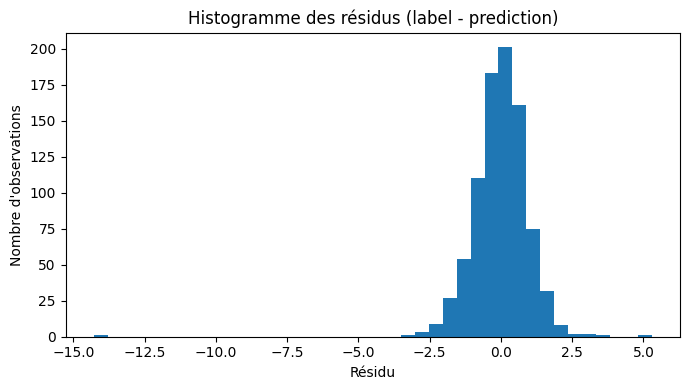

Moyenne des résidus: -0.007263566240059457
Ecart-type des résidus: 1.0225647142198389


In [80]:
import matplotlib.pyplot as plt

# pred = dataframe Spark obtenu après la régression log1p (celui avec label + prediction)
res_pdf = pred.select("label", "prediction").toPandas()
res_pdf["residual"] = res_pdf["label"] - res_pdf["prediction"]

plt.figure(figsize=(7,4))
plt.hist(res_pdf["residual"], bins=40)
plt.title("Histogramme des résidus (label - prediction)")
plt.xlabel("Résidu")
plt.ylabel("Nombre d'observations")
plt.tight_layout()
plt.show()

print("Moyenne des résidus:", res_pdf["residual"].mean())
print("Ecart-type des résidus:", res_pdf["residual"].std())


L’histogramme des résidus (label − prediction) est centré autour de 0, ce qui indique que le modèle n’est pas fortement biaisé (moyenne des résidus ≈ 0). La majorité des erreurs reste relativement proche de 0, mais on observe quelques valeurs extrêmes, ce qui suggère que certains clients (notamment atypiques ou très dépensiers) sont plus difficiles à prédire, même après transformation log.


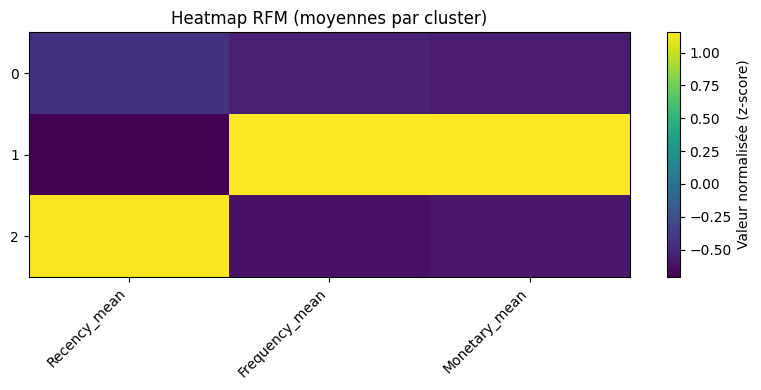

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

cluster_summary = (
    rfm_clustered
    .groupBy("cluster")
    .avg("Recency", "Frequency", "Monetary")
    .toPandas()
)

cluster_summary = cluster_summary.rename(columns={
    "avg(Recency)": "Recency_mean",
    "avg(Frequency)": "Frequency_mean",
    "avg(Monetary)": "Monetary_mean"
}).sort_values("cluster")

heatmap_data = cluster_summary.set_index("cluster")
heatmap_norm = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()

plt.figure(figsize=(8, 4))
plt.imshow(heatmap_norm.values, aspect="auto")
plt.xticks(range(len(heatmap_norm.columns)), heatmap_norm.columns, rotation=45, ha="right")
plt.yticks(range(len(heatmap_norm.index)), heatmap_norm.index)
plt.colorbar(label="Valeur normalisée (z-score)")
plt.title("Heatmap RFM (moyennes par cluster)")
plt.tight_layout()
plt.show()


La heatmap met en évidence trois segments clients : un cluster à forte valeur (achats récents, fréquence et dépenses élevées), un cluster dormant (dernier achat ancien, faible activité) et un cluster intermédiaire. Ces résultats permettent de recommander des actions ciblées : fidélisation pour les VIP, upsell pour les clients moyens, et campagnes de réactivation pour les clients dormants.


### Actions & recommandations

Les clusters RFM permettent de mettre en place des actions marketing ciblées : le cluster à forte valeur (fréquence et dépenses élevées, achats récents) doit être priorisé via des stratégies de fidélisation (offres exclusives, programme premium), tandis que le cluster intermédiaire peut être travaillé via de l’upsell/cross-sell (bundles, recommandations produits, seuil de livraison gratuite). Le cluster dormant (recency élevée, faible activité) correspond à des clients à risque : une stratégie de réactivation (win-back, promotions limitées, relances personnalisées) est recommandée.

Pour convertir les “petits dépensiers” en “gros dépensiers”, on peut combiner la segmentation et la classification : identifier les clients à faible dépense mais fréquence correcte, puis proposer des incitations progressives (réductions sur panier minimum, offres personnalisées, produits complémentaires) afin d’augmenter le panier moyen. 

Enfin, Le modèle supervisé peut être intégré dans un pipeline en production de manière simple : à intervalles réguliers (ex : chaque semaine), l’entreprise met à jour les variables RFM de chaque client (Recency, Frequency, Monetary), puis applique automatiquement le modèle pour générer un score. Ce score peut être une probabilité d’être “gros dépensier” (classification) ou une valeur estimée (régression). Ensuite, ce score est utilisé pour déclencher des actions marketing ciblées : offres VIP pour les clients à forte valeur, upsell pour les clients intermédiaires, ou campagnes de réactivation pour les clients inactifs.

